# CIFAR-10 Convolutional Neural Network

In [1]:
import torch
import numpy as np

trainOnGPU = torch.cuda.is_available()
if not trainOnGPU:
    print("CUDA is not available. Training on CPU")
else:
    print("CUDA is available. Training on GPU")

CUDA is not available. Training on CPU


In [7]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

numOfWorkers = 0 # num of subprocesses to use for data loading
batchSize = 20
validation = 0.2

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainData = datasets.CIFAR10("data",train=True,download=True,transform = transform)
testData = datasets.CIFAR10("data",train=False, download = True, transform = transfrom)

# obtain training indices
numOfTrain = len(trainData)
indices = list(range(numOfTrain))
np.random.shuffle(indices)
split = int(np.floor(validation*numOfTrain))
trainIdx,validIdx = indices[split:],indices[:split]

trainSampler = SubsetRandomSampler(trainIdx)
validSampler = SubsetRandomSampler(validIdx)

trainLoader = torch.utils.data.DataLoader(trainData,batch_size=batchSize, sampler = trainSampler,num_workers = numOfWorkers)
validationLoader=torch.utils.data.DataLoader(trainData,batch_size=batchSize, sampler = validSampler,num_workers = numOfWorkers)
testLoader = torch.utils.data.DataLoader(testData,batch_size=batchSize,num_workers = numOfWorkers)

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Files already downloaded and verified
Files already downloaded and verified


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img,(1,2,0)))

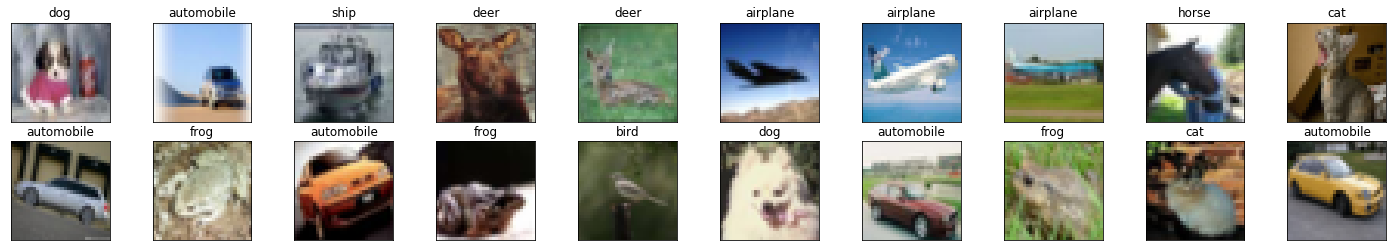

In [33]:
it = iter(trainLoader)
images, labels = it.next()
images = images.numpy() # to numpy for display

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

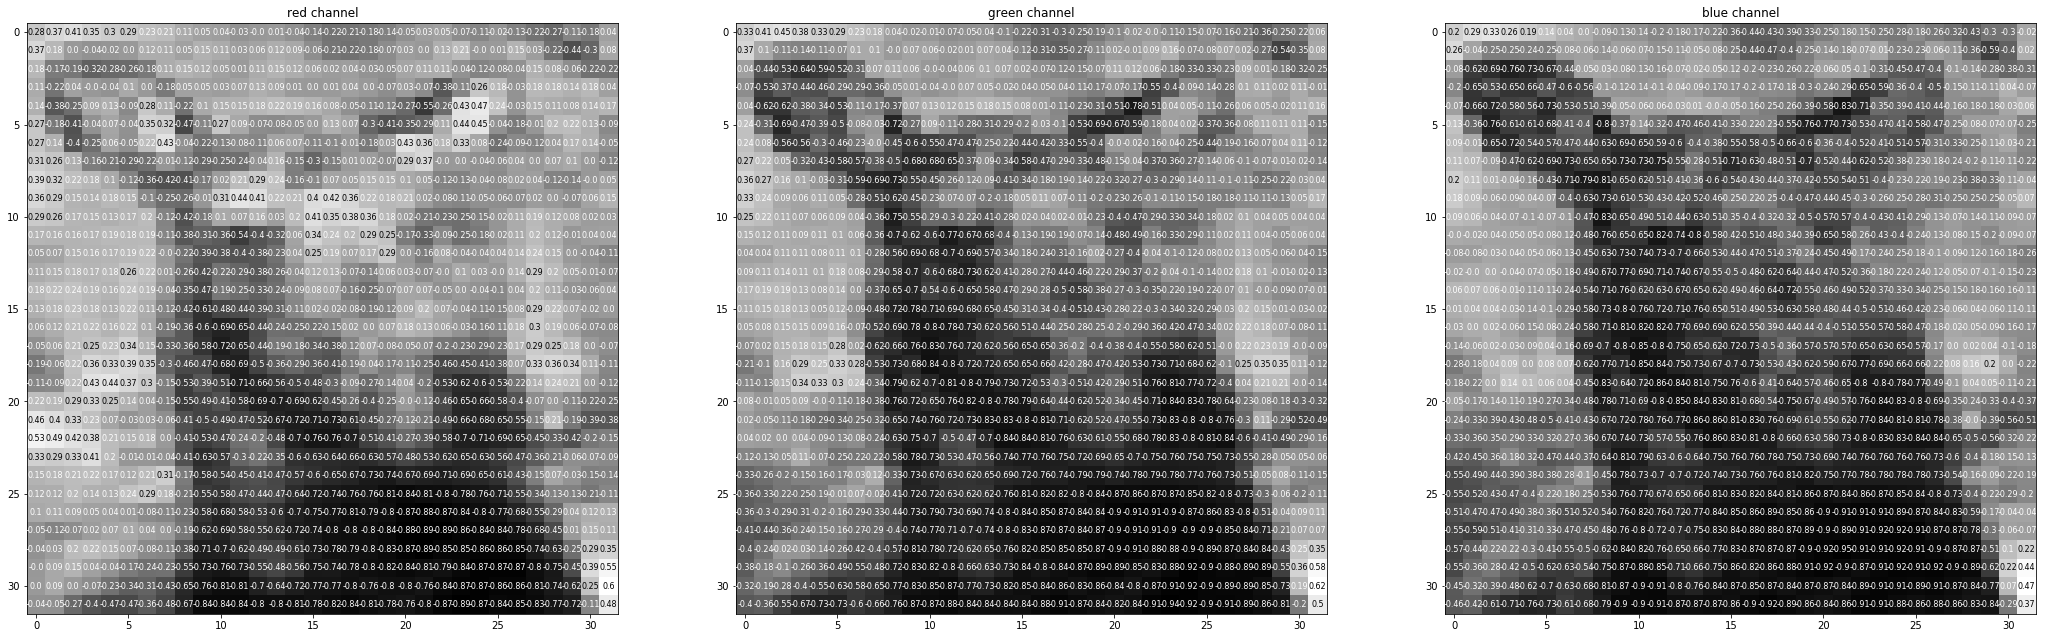

In [34]:
# view an image in more detail
rgbImg = images[3]
channels = ["red channel","green channel","blue channel"]
fig = plt.figure(figsize = (36,36))
for idx in np.arange(rgbImg.shape[0]):
    ax = fig.add_subplot(1,3,idx+1)
    img = rgbImg[idx]
    ax.imshow(img,cmap="gray")
    ax.set_title(channels[idx])
    width,height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] != 0 else 0
            ax.annotate(str(val),xy=(y,x),horizontalalignment="center",
                        verticalalignment="center",size = 8,color="white" if img[x][y]<thresh else "black")

In [37]:
rgbImg.shape

(3, 32, 32)

In [47]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
                               # sees 32x32x3, outputs 16 channels with 3x3 kernel
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
                                # sees 16x16x16 tensor
        self.conv2 = nn.Conv2d(16,32,3,padding = 1) # sees 16 channels and outputs 32 channels 
                                # sees 8x8x32 tensor
        self.conv3 = nn.Conv2d(32,64,3,padding = 1)
        self.pool = nn.MaxPool2d(2,2)
                                # sees 4x4x64 tensor
        self.fc1 = nn.Linear(64*4*4,500)
        self.fc2 = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        # flatten the image
        x = x.view(-1,64*4*4)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
model = Model()
print(model)

if trainOnGPU:
    model.cuda()
        
        

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
  (relu): ReLU()
  (softmax): LogSoftmax()
)


In [49]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01)

In [51]:
numOfEpochs = 30
validLossMin = np.Inf
for epoch in range(numOfEpochs):
    trainLoss = 0.0
    validLoss = 0.0
    model.train()
    for data,target in trainLoader:
        if trainOnGPU:
            data = data.cuda()
            target = target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item()*data.size(0)
    model.eval()
    for data,target in validationLoader:
        if trainOnGPU:
            data,target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output,target)
        validLoss += loss.item() * data.size(0)
    trainLoss = trainLoss / len(trainLoader.sampler)
    validLoss = validLoss / len(validationLoader.sampler)
    
    print("Epoch: {}\tTraining Loss:{:.6f}\tValidation Loss: {:.6f}".format(epoch,trainLoss,validLoss)) 

Epoch: 0	Training Loss:1.661969	Validation Loss: 1.510656
Epoch: 1	Training Loss:1.474172	Validation Loss: 1.357900
Epoch: 2	Training Loss:1.360474	Validation Loss: 1.266427
Epoch: 3	Training Loss:1.267087	Validation Loss: 1.181775
Epoch: 4	Training Loss:1.179633	Validation Loss: 1.164793
Epoch: 5	Training Loss:1.111479	Validation Loss: 1.039495
Epoch: 6	Training Loss:1.053384	Validation Loss: 1.013130
Epoch: 7	Training Loss:0.995268	Validation Loss: 0.966243
Epoch: 8	Training Loss:0.947437	Validation Loss: 0.917272
Epoch: 9	Training Loss:0.903709	Validation Loss: 0.897668
Epoch: 10	Training Loss:0.860250	Validation Loss: 0.850705
Epoch: 11	Training Loss:0.824056	Validation Loss: 0.811925
Epoch: 12	Training Loss:0.787726	Validation Loss: 0.807100
Epoch: 13	Training Loss:0.753076	Validation Loss: 0.819476
Epoch: 14	Training Loss:0.724564	Validation Loss: 0.754737
Epoch: 15	Training Loss:0.694996	Validation Loss: 0.752229
Epoch: 16	Training Loss:0.668908	Validation Loss: 0.751165
Epoch: 

In [53]:
testLoss =0.0
classCorrect = list(0. for i in range(10))
classTotal = list(0. for i in range(10))
print(classCorrect)

model.eval()

for data,target in testLoader:
    if trainOnGPU:
        data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = criterion(output,target)
    testLoss += loss.item() * data.size(0)
    _,pred = torch.max(output,1)
    
    #compare pred to true label
    correctTensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correctTensor.numpy()) if not trainOnGPU else np.squeeze(correctTensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batchSize):
        label = target.data[i]
        classCorrect[label] += correct[i].item()
        classTotal[label] += 1
testLoss = testLoss / len(testLoader.dataset)
print("Test loss: {:.6f}\n".format(testLoss))

for i in range(10):
    if classTotal[i] > 0:
        print("Test accuracy of %5s: %2d%% (%2d/%2d)" % (classes[i], 100 *classCorrect[i]/classTotal[i],
                                                        np.sum(classCorrect[i]),np.sum(classTotal[i])))
    else:
        print("Test accuracy of %5s: N/A (no training example)" % (classes[i]))

print("\nTest Accuracy (Overall): %2d%% (%2d/%2d)" % (100.*np.sum(classCorrect)/np.sum(classTotal),
             np.sum(classCorrect),np.sum(classTotal)))


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test loss: 0.767933

Test accuracy of airplane: 78% (785/1000)
Test accuracy of automobile: 84% (842/1000)
Test accuracy of  bird: 67% (675/1000)
Test accuracy of   cat: 55% (553/1000)
Test accuracy of  deer: 73% (735/1000)
Test accuracy of   dog: 60% (602/1000)
Test accuracy of  frog: 85% (857/1000)
Test accuracy of horse: 78% (784/1000)
Test accuracy of  ship: 91% (915/1000)
Test accuracy of truck: 77% (771/1000)

Test Accuracy (Overall): 75% (7519/10000)


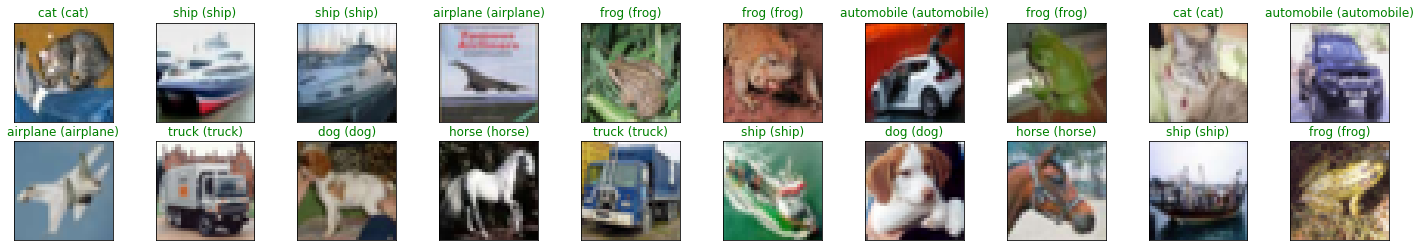

In [65]:
it = iter(testLoader)
images,labels  = it.next()
images.numpy()

if trainOnGPU:
    images = images.cuda()

output = model(images)
_,preds_tensor = torch.max(output,1)

preds = np.squeeze(preds_tensor.numpy() if not trainOnGPU else np.squeeze(preds_tensor.cpu().numpy()))

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx]]),
                    color = ("green" if preds[idx] ==labels[idx].item() else "red"))
    